In [1]:
import numpy as np
import magpylib as magpy
import matplotlib.pyplot as plt

In [3]:
mu0 = 4*np.pi*1e-7 # T*m/A
gamma_h = 42.5756  # MHz/T
b_z_earth = 65E-6 # T
rho_c = 1.678E-8  # ohm*m

# Maxwell Coil

In [4]:
# m axwell coil
R0 = 105 # mm
R1 = R0*np.sqrt(4./7)

# lateral coil distance from center
d_lc = R0*np.sqrt(3./7)

R0, R1, d_lc

(105, 79.37253933193772, 68.73863542433759)

In [5]:
d0 = (30.0/17) # mm wire diameter


wire_multiply = 2
# central coil number of spire
n_cc = wire_multiply * 64

n_cc_h = int(np.sqrt(n_cc))+1
n_cc_v = int(n_cc/n_cc_h)+1


# lateral coil number of spire
n_lc = wire_multiply * 49

n_lc_h = int(np.sqrt(n_lc))
n_lc_v = int(n_lc/n_lc_h)+1


print("central coil turns:", n_cc, n_cc_h, n_cc_v, n_cc_h*n_cc_v, "\nlateral coil turns:", n_lc, n_lc_h, n_lc_v, n_lc_h*n_lc_v)

central coil turns: 128 12 11 132 
lateral coil turns: 98 9 11 99


### Generate all spirals 
spiral defined by tuple: (radius, distance from center)

In [6]:
# start wire positions
start_cc_p = -(n_cc_h)*d0/2.
start_lc_p = -(n_lc_h)*d0/2.

print("central position:", f"{start_cc_p:.3f}", f"{start_cc_p+d0*n_cc_h:.3f}")

# start wire radius
start_cc_r = R0-(n_cc_v)*d0/2.
start_lc_r = R1-(n_lc_v)*d0/2.

print("lateral position:", f"{start_lc_p:.3f}", f"{start_lc_p+d0*n_lc_h:.3f}")
# horizontal wire position
c_wp = np.arange(start_cc_p, start_cc_p+d0*n_cc_h, d0)
l_wp = np.arange(start_lc_p, start_lc_p+d0*n_lc_h, d0)

c_wr = np.arange(start_cc_r, start_cc_r+d0*n_cc_h, d0)
l_wr = np.arange(start_lc_r, start_lc_r+d0*n_lc_h, d0)

c_w = []
l_w = []

for z in c_wp:
    for r in c_wr:
        c_w.append((r, z))

for z in l_wp+d_lc:
    for r in l_wr:
        l_w.append((r, z))

print("central radial:", f"{start_cc_r:.3f}", f"{start_cc_r+d0*n_cc_v:.3f}")
print("lateral radial:", f"{start_lc_r:.3f}", f"{start_lc_r+d0*n_lc_v:.3f}")

central position: -10.588 10.588
lateral position: -7.941 7.941
central radial: 95.294 114.706
lateral radial: 69.667 89.078


### Electrical Properties

In [8]:
I = 5
L_c = 0 # mm
L_l = 0 # mm
d_copper = 0.6
for i in c_w:
    r, z = i
    L_c += 2*r*np.pi

for i in l_w:
    r, z = i
    L_l += 2*np.pi*r

print("Lunghezza filo bobina centrale:", f"{(L_c)*1e-3:.2f}", "m")
print("Lunghezza filo bobina laterale:", f"{(L_l)*1e-3:.2f}", "m")
print("Lunghezza totale del filo:", f"{(L_c+2*L_l)*1e-3:.2f}", "m")


a_w = 0.25e-6 #np.power(d_copper/2., 2)*np.pi*1e-6

R = rho_c*(L_c+2*L_l)*1e-3/a_w
V = I*R

print("Resistenza totale del filo:", f"{R:.2e}", "Ohm")
print("Voltaggio Richiesto:", f"{V:.2f}", "V")
print("Potenza alimentatore:", f"{I*I*R:.2f}", "W")

Lunghezza filo bobina centrale: 95.00 m
Lunghezza filo bobina laterale: 39.05 m
Lunghezza totale del filo: 173.10 m
Resistenza totale del filo: 1.21e-04 Ohm
Voltaggio Richiesto: 0.00 V
Potenza alimentatore: 0.00 W


### Computing with magpylib

In [76]:
import matplotlib.pylab as pl
from matplotlib.colors import ListedColormap

cmap = pl.cm.Greys
my_cmap = cmap(np.arange(cmap.N))
my_cmap[:,-1] = np.linspace(0.0, 1.0, cmap.N)
my_cmap_grey = ListedColormap(my_cmap)

cmap = pl.cm.jet
my_cmap = cmap(np.arange(cmap.N))
my_cmap[:,-1]*=0.4
my_cmap_jet = ListedColormap(my_cmap)

cmap = pl.cm.turbo
my_cmap = cmap(np.arange(cmap.N))
my_cmap[:,-1] = 0.6
my_cmap_turbo = ListedColormap(my_cmap)

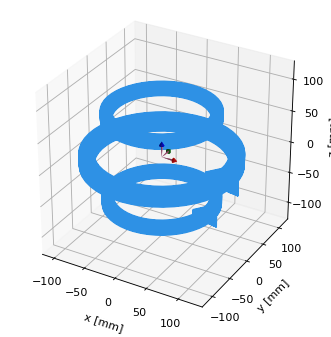

In [86]:
coils = []

for i in l_w:
    r, z = i
    coils.append( magpy.current.Loop(current=I, diameter=2*r, position=(0, 0, -z)) )
for i in l_w:
    r, z = i
    coils.append( magpy.current.Loop(current=I, diameter=2*r, position=(0, 0, z)) )
    
for i in c_w:
    r, z = i
    coils.append( magpy.current.Loop(current=I, diameter=2*r, position=(0, 0, z)) )

total_coil = coils[0]
for i in coils[1:]:
    total_coil+=i

sensor = magpy.Sensor()

fig = magpy.show(total_coil, sensor, return_fig=True)
fig.set_figwidth(5)

size = 200
ts = np.linspace(-110, 110, size)
X, Y = np.meshgrid(ts, ts)
grid = np.array([[(x,0,z) for x in ts] for z in ts])

In [78]:
# Magnetic field 3 comp in space
B = total_coil.getB(grid)

In [62]:
# magnetic field at the center
B_center = total_coil.getB(sensor)[2]
print("Magnetic Field at the center:", f"{B_center:.2f}", "mT")
B_homo = np.ones((size, size))*B_center

print("Fattore di scala terrestre B0/Bt: ", f"{B_center/1000/b_z_earth:.2f}")
freq = gamma_h*B_center
print("Frequenza di funzionamento:", f"{freq:0.2f}", "kHz")

B_teor = I*mu0*60.*1000/R0/1e-3
print("B teorical:", f"{B_teor:.2f}", "mT")

Magnetic Field at the center: 8.44 mT
Fattore di scala terrestre B0/Bt:  129.86
Frequenza di funzionamento: 359.39 kHz
B teorical: 3.59 mT


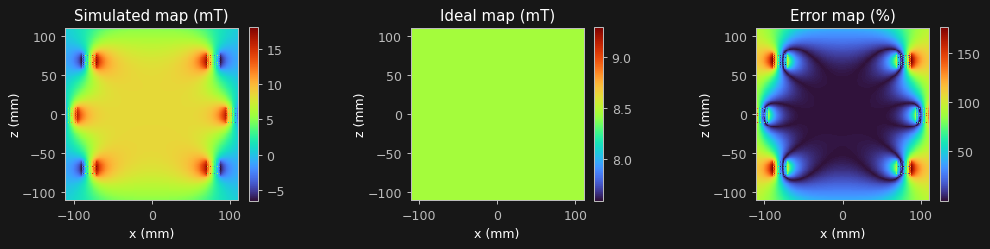

In [63]:
fig = plt.figure(figsize=(13,2.5), dpi=90, facecolor="#171717")

ax=plt.subplot(1, 3, 1)
ax.set_aspect(1)
ax.tick_params(color='#bbb', labelcolor='#bbb')
for spine in ax.spines.values():
    spine.set_edgecolor('#bbb')
p = plt.pcolor(X, Y, B[:,:,2], cmap="turbo")
cb = plt.colorbar(p)
cb.outline.set_edgecolor("#bbb")
cb.ax.tick_params(color='#bbb')
plt.setp(plt.getp(cb.ax.axes, 'yticklabels'), color="#bbb")

plt.ylabel("z (mm)", labelpad=0.1, fontdict={"color":"white"})
plt.xlabel("x (mm)", fontdict={"color":"white"})
plt.title("Simulated map (mT)", fontdict={"color":"white", "fontsize":12})

ax=plt.subplot(1, 3, 2)
ax.set_aspect(1)
ax.tick_params(color='#bbb', labelcolor='#bbb')
for spine in ax.spines.values():
    spine.set_edgecolor('#bbb')
p = plt.pcolor(X, Y, B_homo, cmap="turbo")
cb = plt.colorbar(p)
cb.outline.set_edgecolor("#bbb")
cb.ax.tick_params(color='#bbb')
plt.setp(plt.getp(cb.ax.axes, 'yticklabels'), color="#bbb")
plt.ylabel("z (mm)", labelpad=0.1,  fontdict={"color":"white"})
plt.xlabel("x (mm)", fontdict={"color":"white"})
plt.title("Ideal map (mT)", fontdict={"color":"white","fontsize":12})

err = np.abs((B_homo-B[:,:,2]))/B_center
ax=plt.subplot(1, 3, 3)
ax.set_aspect(1)
ax.tick_params(color='#bbb', labelcolor='#bbb')
for spine in ax.spines.values():
    spine.set_edgecolor('#bbb')
p = plt.pcolor(X, Y, err*100, cmap="turbo")
cb = plt.colorbar(p)
cb.outline.set_edgecolor("#bbb")
cb.ax.tick_params(color='#bbb')
plt.setp(plt.getp(cb.ax.axes, 'yticklabels'), color="#bbb")
plt.ylabel("z (mm)", labelpad=-0.2, fontdict={"color":"white"})
plt.xlabel("x (mm)", fontdict={"color":"white"})
plt.title("Error map (%)", fontdict={"color":"white","fontsize":12})

plt.subplots_adjust(wspace=0.6)
plt.show()


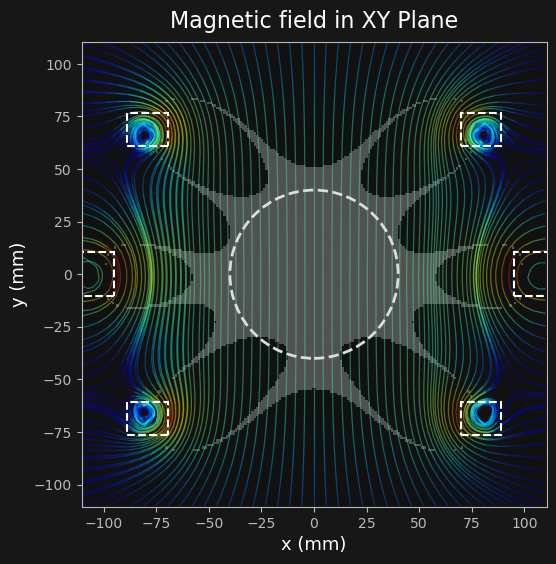

In [92]:
fig = plt.figure(figsize=(6, 8), facecolor="#171717")

ax =  fig.subplots(1, 1)
ax.set_aspect(1)

ax.tick_params(color='#bbb', labelcolor='#bbb')
for spine in ax.spines.values():
    spine.set_edgecolor('#bbb')

l = ax.streamplot(
    grid[:,:,0], grid[:,:,2], B[:,:,0], B[:,:,2], 
    color=np.linalg.norm(B, axis=2), 
    linewidth=0.9, #0.2*np.linalg.norm(np.power(np.abs(B), 1.1), axis=2),
    density=1.3,
    cmap=my_cmap_jet, 
    zorder=-2, 
    arrowsize = 0,
    broken_streamlines=False)

ax.set_facecolor("#171717")
# plt.grid()
r = 40
# ax.add_artist(plt.Circle((0, 0), r, alpha=0.3, linewidth=0, color="#ce5449", zorder=-2))
ax.add_artist(plt.Circle((0, 0), r, fill=False, linewidth=2, linestyle="dashed", zorder=-2, edgecolor="#ddd"))
ax.pcolormesh(X, Y, err>0.01, cmap=my_cmap_grey, zorder=-4, edgecolor='none', alpha=0.25)

ax.add_artist(plt.Rectangle((start_cc_r, start_cc_p), d0*n_cc_v, d0*n_cc_h, fill=False, linestyle="dashed", edgecolor="white", linewidth=1.5))
ax.add_artist(plt.Rectangle((-start_cc_r, start_cc_p), -d0*n_cc_v, d0*n_cc_h, fill=False, linestyle="dashed", edgecolor="white", linewidth=1.5))

ax.add_artist(plt.Rectangle((-start_lc_r,  d_lc+start_lc_p), -d0*n_lc_v, d0*n_lc_h, fill=False, linestyle="dashed", edgecolor="white", linewidth=1.5))
ax.add_artist(plt.Rectangle((start_lc_r,  d_lc+start_lc_p), d0*n_lc_v, d0*n_lc_h, fill=False, linestyle="dashed", edgecolor="white", linewidth=1.5))
ax.add_artist(plt.Rectangle((-start_lc_r,  -d_lc+start_lc_p), -d0*n_lc_v, d0*n_lc_h, fill=False, linestyle="dashed", edgecolor="white", linewidth=1.5))
ax.add_artist(plt.Rectangle((start_lc_r,  -d_lc+start_lc_p), d0*n_lc_v, d0*n_lc_h, fill=False, linestyle="dashed", edgecolor="white", linewidth=1.5))

ax.set_xlabel("x (mm)", fontdict={"color":"white", "fontsize":13})
ax.set_ylabel("y (mm)", fontdict={"color":"white", "fontsize":13})
ax.set_title("Magnetic field in XY Plane", fontdict={"color":"white", "fontsize":16}, pad=10)
plt.show()